# About

Given some dataset about flight delays, estimate them using ML approaches.

In this report:
* Description of the dataset
* IQR for preprocessing
* Models applied:
    * sklearn.LinearRegression
    * sklearn.Perceptron
    * sklearn.LogisticRegression
* Brief conclusion

## Read the data and simply check, what we have got

The common approach for working with datasets in almost any format is to use Pandas library [https://pandas.pydata.org/].

We have stored the data file in the same folder, so the datapath is "current path".

In order to control the memory management, we will use Pandas enumerations.

In [255]:
# For models, we will use Scikit-learn
import sklearn
# For data manipulation, pandas
import pandas as pd
import numpy as np
# Both include Matplotlib to show the results
import matplotlib.pyplot as plt
# And any notebook-runner supports some printing stuff
from IPython.display import HTML, display

import warnings
warnings.filterwarnings('ignore')


data_path = './'
df = pd.read_csv(
    data_path + 'flight_delay.csv', 
    sep=',', 
    parse_dates=['Scheduled depature time', 'Scheduled arrival time'])
df['Depature Airport'] = df['Depature Airport'].astype("category")
df['Destination Airport'] = df['Destination Airport'].astype("category")
print(df.info())

ft, col, col2 = 'Flight duration', 'Scaled delay', 'Scaled outliers'
code1, code2 = 'Encoded departure', 'Encoded destination'

from sklearn import preprocessing as prp

scaler = prp.RobustScaler(quantile_range=(20., 80.))
encoder1, encoder2 = prp.LabelEncoder(), prp.LabelEncoder()

encoder1.fit(df['Depature Airport'])
encoder2.fit(df['Destination Airport'])

df[code1], df[code2] = encoder1.transform(df['Depature Airport']), encoder2.transform(df['Destination Airport'])


X, Y = sklearn.model_selection.train_test_split(df, test_size=.2, shuffle=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675513 entries, 0 to 675512
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Depature Airport         675513 non-null  category      
 1   Scheduled depature time  675513 non-null  datetime64[ns]
 2   Destination Airport      675513 non-null  category      
 3   Scheduled arrival time   675513 non-null  datetime64[ns]
 4   Delay                    675513 non-null  float64       
dtypes: category(2), datetime64[ns](2), float64(1)
memory usage: 18.0 MB
None


### Removing outliers 

We will apply IQR to track them.
Actually, we will separate them.

To do so, Scikit recommends to use RobustScaler.

<AxesSubplot:title={'center':'Outliers'}, xlabel='Scheduled depature time'>

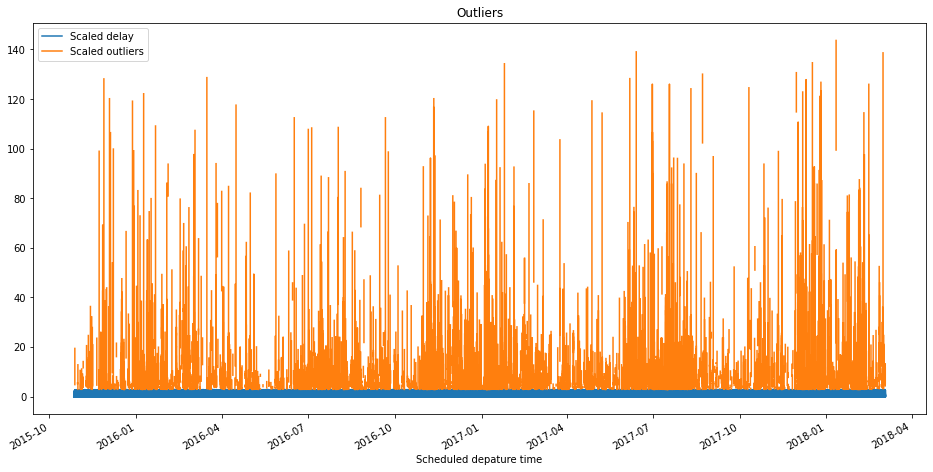

In [241]:
X[ft] = (X['Scheduled arrival time'] - X['Scheduled depature time']) / np.timedelta64(1, 's')
X[ft] /= X[ft].max()

# IQR to go
X[col] = scaler.fit_transform(X['Delay'].to_numpy().reshape(-1,1))

q3, q1 = X[col].quantile(.75), X[col].quantile(.25)
iqr = q3 - q1

X.loc[:, col2] = np.where(
    (X[col] >= q1 - 3*iqr) & (X[col] <= q3 + 3*iqr), np.NaN, X[col])
X.loc[:, col] = np.where(
    (X[col] >= q1 - 3*iqr) & (X[col] <= q3 + 3*iqr), X[col], np.NaN)

# Show results
display(HTML("<h2>All metrics</h2>" + X.describe().to_html() + X.head().to_html()))
X.set_index('Scheduled depature time')[[col, col2]].plot(figsize=(16,8), title='Outliers')

## Test dataset preprocessing

Also, preprocess test dataset in the same way - except keeping the outliers, we will need them.

In [257]:
Y[ft] = (Y['Scheduled arrival time'] - Y['Scheduled depature time']) / np.timedelta64(1, 's')
max_ft = Y[ft].max()
Y[ft] /= max_ft

Y[col] = scaler.fit_transform(Y['Delay'].to_numpy().reshape(-1,1))

Y.head()

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay,Encoded departure,Encoded destination,Flight duration,Scaled delay
540410,KRR,2018-03-04 09:30:00,SVO,2018-03-04 11:50:00,0.0,74,144,0.179487,0.0
540411,SVO,2018-03-04 09:30:00,MRV,2018-03-04 11:50:00,1.0,144,98,0.179487,1.0
540412,SVO,2018-03-04 09:30:00,BRU,2018-03-04 13:15:00,0.0,144,20,0.288462,0.0
540413,SVO,2018-03-04 09:30:00,STR,2018-03-04 12:55:00,0.0,144,142,0.262821,0.0
540414,SVO,2018-03-04 09:35:00,ROV,2018-03-04 11:35:00,0.0,144,126,0.153846,0.0


## Models

Learning will occur only on cleared training dataset.

In [243]:
clear_X = X.drop(columns=[col2]).dropna().copy()

### Linear Regression

Given the coefficients vector W,
fit them in order to achieve the target.

$\min_{w} || X w - y||_2^2$

Obviously, for such data it will not perform "good" enough - there will be an underfitting due to no inference extracted.

MSE:
train score = 0.3412
test score  = 1040.7332


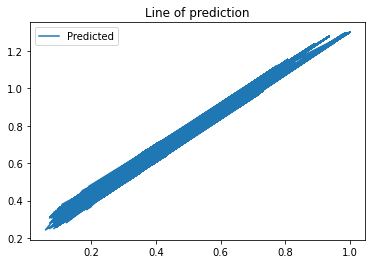

,Scaled delay,Depature Airport,Encoded departure,Destination Airport,Encoded destination,pred_lr
540410,0.0,KRR,74,SVO,144,0.426316
540411,1.0,SVO,144,MRV,98,0.386583
540412,0.0,SVO,144,BRU,20,0.484680
540413,0.0,SVO,144,STR,142,0.494932
540414,0.0,SVO,144,ROV,126,0.366603


In [247]:
from sklearn.linear_model import LinearRegression

model, dirty_model = LinearRegression(), LinearRegression()
model.fit(clear_X[[ft, code1, code2]], clear_X[col])

validation_score = sklearn.metrics.mean_squared_error(
    y_true=clear_X[col], y_pred=model.predict(clear_X[[ft, code1, code2]].to_numpy()))

Y['pred_lr'] = model.predict(Y[[ft, code1, code2]].to_numpy())

test_score = sklearn.metrics.mean_squared_error(y_true=Y[col], y_pred=Y['pred_lr'])

print(f'MSE:\ntrain score = {validation_score:6.4f}\ntest score  = {test_score:6.4f}')

plt.plot(Y[[ft]], Y['pred_lr'], label='Predicted')
plt.title('Line of prediction')
plt.legend()
plt.show()

(Y[[col, 'Depature Airport', code1, 'Destination Airport', code2, 'pred_lr']]).head()

## Perceptron

[https://scikit-learn.org/stable/modules/linear_model.html#perceptron]

The Perceptron is another simple classification algorithm suitable for large scale learning. By default:

* It does not require a learning rate.
* It is not regularized (penalized).
* It updates its model only on mistakes.

The last characteristic implies that the Perceptron is slightly faster to train than SGD with the hinge loss and that the resulting models are sparser.


 

*Alex: either we should have more features from data, or avoid using complex models.*

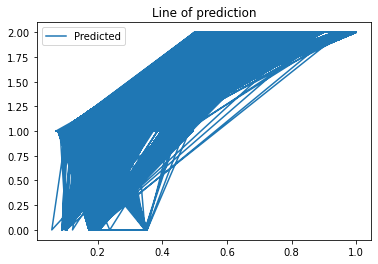

In [248]:
from sklearn.linear_model import Perceptron

model = Perceptron(penalty='l1')

# OK, Perceptron does not like floats as target.
model.fit(X=clear_X[[ft, code1, code2]].values, y=np.asarray(clear_X[col], dtype=int))

y_pred = model.predict(Y[[ft, code1, code2]].to_numpy())

plt.plot(Y[[ft]], y_pred, label='Predicted')
plt.title('Line of prediction')
plt.legend()
plt.show()

In [251]:
validation_score = sklearn.metrics.mean_squared_error(
    y_true=clear_X[col], y_pred=model.predict(clear_X[[ft, code1, code2]].to_numpy()))

Y['pred_perc'] = model.predict(Y[[ft, code1, code2]].to_numpy())

test_score = sklearn.metrics.mean_squared_error(y_true=Y[col], y_pred=Y['pred_perc'])

print(f'MSE:\ntrain score = {validation_score:6.4f}\ntest score  = {test_score:6.4f}')

(Y[[col, 'Depature Airport', code1, 'Destination Airport', code2, 'pred_perc']]).head()

MSE:
train score = 0.7736
test score  = 1036.7304


,Scaled delay,Depature Airport,Encoded departure,Destination Airport,Encoded destination,pred_perc
540410,0.0,KRR,74,SVO,144,1
540411,1.0,SVO,144,MRV,98,1
540412,0.0,SVO,144,BRU,20,1
540413,0.0,SVO,144,STR,142,1
540414,0.0,SVO,144,ROV,126,1


## Logistic regression
Yes, it is about classification. All right, let's "classify" the delay, given both hubs & flight duration.


For L1 regularization, optimizer will look like this:

* $\min_{w, c} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) $, having $y_i$ in range [-1, 1].



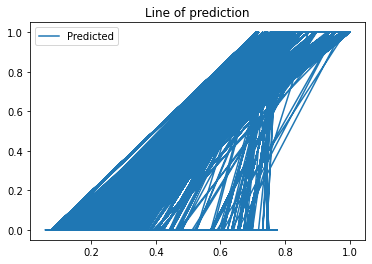

MSE:
train score = 0.4626
test score  = 1044.6236


,Scaled delay,Depature Airport,Encoded departure,Destination Airport,Encoded destination,pred_log
540410,0.0,KRR,74,SVO,144,0
540411,1.0,SVO,144,MRV,98,0
540412,0.0,SVO,144,BRU,20,0
540413,0.0,SVO,144,STR,142,0
540414,0.0,SVO,144,ROV,126,0


In [261]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(penalty='l1', solver='saga')
model.fit(clear_X[[ft, code1, code2]], clear_X[col].astype(int))

validation_score = sklearn.metrics.mean_squared_error(
    y_true=clear_X[col], y_pred=model.predict(clear_X[[ft, code1, code2]].to_numpy()))

Y['pred_log'] = model.predict(Y[[ft, code1, code2]].to_numpy())

test_score = sklearn.metrics.mean_squared_error(y_true=Y[col], y_pred=Y['pred_log'])

plt.plot(Y[[ft]], Y['pred_log'], label='Predicted')
plt.title('Line of prediction')
plt.legend()
plt.show()

print(f'MSE:\ntrain score = {validation_score:6.4f}\ntest score  = {test_score:6.4f}')

(Y[[col, 'Depature Airport', code1, 'Destination Airport', code2, 'pred_log']]).head()

## Brief conclusion

Surprisingly, the simplest model has shown the most adequate results.

But, after a couple of moments, there is nothing surprising - after all, we were tasked to estimate the target. Basically, that's what regression does. Even if there is not so much input data [let's skip an opportunity of playing with given datetimes, please].

For classification tasks, 2 of 3 applied models will produce better results.